In [1]:
import os
import copy
import glob
import tqdm
import random
import sys
import gc
import math
import json
import numpy as np

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
import sklearn

# custom functions
supp_script_path = '../../supp_scripts/'
sys.path.append(supp_script_path) # path for support scripts folder
import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

Could not import custom script CNN


(device(type='cuda'), True)

In [2]:
# To remove warnings
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [3]:
parameter_filename = "parameters_DNN.json" 

In [4]:
# Whole section is to read parameters from the parameter file
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file_train = parameters["input_file_train"] # input file
input_file_test = parameters["input_file_test"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

if not trial:
    run_folder = parameters["run_folder"]

gpu_id = int(parameters["gpu_id"])
if gpu_id != None:
    device = "cuda:" + str(gpu_id)
else:
    gpu_id = 0

fingerprint_type = parameters["fingerprint"]["fingerprint_type"]
fingerprint_size = int(parameters["fingerprint"]["fingerprint_size"])
if fingerprint_type == "morgan":
    fp_radius = int(parameters["fingerprint"]["radius"])

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

epochs = int(parameters["network_parameters"]["epochs"])
learning_rate = float(parameters["network_parameters"]["learning_rate"])
batch_size = int(parameters["network_parameters"]["batch_size"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

if not trial:
    os.system("mkdir " + str(run_folder))

if not trial:
    network_parameter_output = open(str(run_folder) + "/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

In [5]:
# Reading input file
ML_input = input_file_train
with open(ML_input) as f:
    f_readlines = f.readlines()
    

# Finding cluster distribution
num_classes = set([label.strip().split(" ")[1] for label in f_readlines])
class_distriution = su.DNN.get_cluster_count_from_label([label.strip().split(" ")[1] for label in f_readlines])


In [6]:
# DNN network
class Net(nn.Module):
    def __init__(self,p1=0.0,p2=0.0,output_classes=2):
        
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 4096)
        self.drop1 = nn.Dropout(p=p1)
        self.bn1 = nn.BatchNorm1d(4096)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(p=p2)
        self.bn2 = nn.BatchNorm1d(4096)
        
        self.fc3 = nn.Linear(4096, 1024)
        self.drop3 = nn.Dropout(p=p2)

        self.fc4 = nn.Linear(1024, output_classes)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.drop1(self.relu(self.bn1(self.fc1(x))))
        
        x = self.drop2(self.relu(self.bn2(self.fc2(x))))
        
        x = self.drop3(self.relu((self.fc3(x))))
        
        x = self.fc4(x)
        return x

In [7]:
# Reading train_valid and test splits from the file and make it to a dataframe
smiles_label_test = {line.split()[0]:line.split()[1] for line in open(input_file_test,"r").readlines()}
smiles_label_test = dict(sorted(smiles_label_test.items(), key=lambda item: item[1]))

smiles_label_train = {line.split()[0]:line.split()[1] for line in open(input_file_train,"r").readlines()}
smiles_label_train = dict(sorted(smiles_label_train.items(), key=lambda item: item[1]))
label_count = set(list(smiles_label_train.values()))

train_valid_df = su.dict_to_label(smiles_label_train)
train_valid_df = train_valid_df
test_df = su.dict_to_label(smiles_label_test)
test_df = test_df.sample(frac=1).reset_index(drop=True)
print (len(train_valid_df),len(test_df))

3092 344


Best model
LOSS train: 0.29383336538555976  val: 0.20906293466687204 	ACCU train: 0.9489942528735632  val: 0.9625
Final model
LOSS train: 0.29383336538555976  val: 0.20906293466687204 	ACCU train: 0.9489942528735632  val: 0.9625


KeyboardInterrupt: 

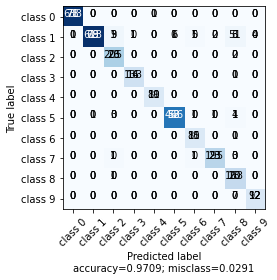

In [8]:
for fold in range(k_fold_value):
    
    if not trial:
        log_file = open(str(run_folder) + "/model_" + str(fold) + ".txt","w")
        model_output_name = str(run_folder) + "/model_" + str(fold) + ".pth" 
        
    piece_count = fold + 1
    
    # create train and valid set for the fold
    train,valid,piece_count = su.CV.get_K_fold_cv_data(train_valid_df,k_fold_value,piece_count,shuffle_output=True)
    
    # Get fingerprint for train, valid, test
    x_train_fp,y_train_fp = su.DNN.smiles_to_fp(train,fingerprint_type,fp_radius,fingerprint_size)
    x_valid_fp,y_valid_fp = su.DNN.smiles_to_fp(valid,fingerprint_type,fp_radius,fingerprint_size)
    x_test_fp,y_test_fp = su.DNN.smiles_to_fp(test_df,fingerprint_type,fp_radius,fingerprint_size)
    
    
    # Creating dataloader
    train_loader = su.CV.get_dataloader(x_train_fp,y_train_fp,batch_size)
    valid_loader = su.CV.get_dataloader(x_valid_fp,y_valid_fp,batch_size)
    test_loader = su.CV.get_dataloader(x_test_fp,y_test_fp,batch_size)
    
    # Writing output
    if not trial:
        train_class_distriution = su.DNN.get_cluster_count_from_label(y_train_fp)
        valid_class_distriution = su.DNN.get_cluster_count_from_label(y_valid_fp)
        test_class_distriution = su.DNN.get_cluster_count_from_label(y_test_fp)
        log_file.write("Training : Class distribution = " + str(train_class_distriution) + "\n")
        log_file.write("Valid : Class distribution = " + str(valid_class_distriution) + "\n")
        log_file.write("Test : Class distribution = " + str(test_class_distriution) + "\n")
    
    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train)).cuda(gpu_id)
        if not trial:
            log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
    
    # initializing network
    model = Net(p1=0.4,p2=0.4,output_classes=len(label_count))
    model.cuda(gpu_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    
    # Training the network
    # List to store values
    train_loss_list = []
    train_accu_list = []

    val_loss_list = []
    val_accu_list = []
    
    train_f1_list = []
    valid_f1_list = []
    # model training
    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.DNN.train(model,criterion,optimizer,train_loader,device)
        val_loss,val_accu = su.DNN.validate(model,criterion,valid_loader,device)
        
        
        # For callback
        # Callback saves the best model based on the below priority
        # validation loss --> validation accuracy--> training loss--> training accuracy
        if epoch == 0:
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1
            
        if epoch != 0:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                model_copy = copy.deepcopy(model)
                saved_model_id = epoch + 1
        
        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
    
    torch.save(model_copy.state_dict(), model_output_name)
    
    log_file.write("\nChosen model = epoch number " + str(saved_model_id))
    
    
    # Re-initializing the model for getting statistics for all the three sets of data for the current fold
    model = Net(p1=0.4,p2=0.4,output_classes=len(label_count))
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)
    
    
    if not trial: # classification report and confusion matrix plot
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,train_loader,device)
        image_name = str(run_folder) + "/train_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,valid_loader,device)
        image_name = str(run_folder) + "/valid_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,test_loader,device)
        image_name = str(run_folder) + "/test_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
    
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
    
    # best validation loss
    index = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    print ("Best model")
    print ("LOSS train:",train_loss_list[index]," val:",val_loss_list[index], "\tACCU train:",train_accu_list[index]," val:",val_accu_list[index])
    print ("Final model")    
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)